# Fanal, a neutrino-less beta decay experiment 

## An open exercise

### Signal Estimation from data - Counting Experiment

#### USC, Master de Física, Física de Partículas II


J. A. Hernando-Morata, with the help of J. Muñoz, J. M. Benlloch, B. Palmeiro, G. Díaz.

February 2021 - February 2022

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

#### Importing modules

In [2]:
import numpy  as np
import tables as tb
import pandas as pd
import matplotlib.pyplot as plt

import scipy.constants as constants
import scipy.stats     as stats
import scipy.optimize  as optimize

import warnings
warnings.filterwarnings('ignore')

In [3]:
# REMEMBER TO ADD your Fanal FOLDER TO PYTHONPATH
import os
import sys
dirpath = os.getcwd()[:-9]
print('add path to PYTHONPATH : ', dirpath)
sys.path.insert(0, os.path.abspath(dirpath))

add path to PYTHONPATH :  /Users/hernando/work/docencia/master/Fisica_Particulas/USC-Fanal


In [4]:
import core.pltext  as pltext   # extensions for plotting histograms
import core.hfit    as hfit     # extension to fit histograms
import core.efit    as efit     # Fit Utilites - Includes Extend Likelihood Fit with composite PDFs
import core.utils   as ut       # generic utilities
import ana.fanal    as fn       # analysis functions specific to fanal
import     collpars as collpars # collaboration specific parameters
pltext.style()

## Indications

### Goal

  **Estimate the number of signal events in data. Estimate the half-life value**.

### Indications

   * Get the data
   
   * Count the number of events in RoI compared with the Bkg estimation 
   
   * Measure the half-life.
   

## Main Parameters

In [5]:
coll          = collpars.collaboration
ntracks_range = collpars.ntracks_range
eblob2_range  = collpars.eblob2_range
erange        = collpars.erange
eroi          = collpars.eroi

print('Collaboration             : {:s}'.format(coll))
print('number of tracks range    : ({:d}, {:6.2f})'.format(*ntracks_range))
print('Blob-2 energy range       : ({:6.3f}, {:6.3f}) MeV'.format(*eblob2_range))
print('Energy range              : ({:6.3f}, {:6.3f}) MeV'.format(*erange))
print('Energy RoI range          : ({:6.3f}, {:6.3f}) MeV'.format(*eroi))

Collaboration             : new_beta
number of tracks range    : (1,   1.10)
Blob-2 energy range       : ( 0.400,  1.200) MeV
Energy range              : ( 2.400,  2.700) MeV
Energy RoI range          : ( 2.430,  2.480) MeV


In [13]:
# list of the selection variables names and ranges
varnames  = ['num_tracks', 'blob2_E', 'E', 'E']
varranges = [ntracks_range, eblob2_range, erange, eroi]
print('varnames  : ', varnames)
print('varranges : ', varranges)

varnames  :  ['num_tracks', 'blob2_E', 'E', 'E']
varranges :  [(1, 1.1), (0.4, 1.2), (2.4, 2.7), (2.43, 2.48)]


In [14]:
nevts_Bi_RoI  = collpars.nevts_Bi_RoI
nevts_Tl_RoI  = collpars.nevts_Tl_RoI
unevts_Bi_RoI = collpars.unevts_Bi_RoI
unevts_Tl_RoI = collpars.unevts_Tl_RoI

print('Number Bi events in RoI = {:6.3f} +- {:6.3f}'.format(nevts_Bi_RoI, unevts_Bi_RoI))
print('Number Tl events in RoI = {:6.3f} +- {:6.3f}'.format(nevts_Tl_RoI, unevts_Tl_RoI))

Number Bi events in RoI = 21.659 +-  0.991
Number Tl events in RoI =  4.006 +-  0.035


## Access the data

In [15]:
filename = '/data/fanal_'+ coll + '.h5'
print('Data : ', dirpath + filename)

mcbi = pd.read_hdf(dirpath + filename, key = 'mc/bi214')
mctl = pd.read_hdf(dirpath + filename, key = 'mc/tl208')

datab = pd.read_hdf(dirpath + filename, key = 'data/blind')
datar = pd.read_hdf(dirpath + filename, key = 'data/roi')
data  = pd.concat((datab, datar)) # concatenate blind and roi-data into one data DF

Data :  /Users/hernando/work/docencia/master/Fisica_Particulas/USC-Fanal/data/fanal_new_beta.h5


In [19]:
def plt_fanal(data, sel, mcs, nbkgs, nbins = 20):
    ranges = {'E' : eroi, 'blob2_E': eblob2_range}
    def _plot(varname):
        labels = [r"$^{214}$Bi", r"$^{108}$Tl"]
        counts, bins = np.histogram(data[sel][varname], nbins, range = ranges[varname])
        cbins = 0.5 * (bins[1:] + bins[:-1])
        esel  = counts > 0
        ecounts = np.sqrt(counts)
        plt.errorbar(cbins[esel], counts[esel], yerr = ecounts[esel], marker = 'o', ls = '', label = 'data');
        i = 0
        for n, mc in zip(nbkgs, mcs):
            ucounts, _   = np.histogram(mc[varname], bins)
            ucounts      = n * ucounts/np.sum(ucounts)
            plt.plot(cbins, ucounts, label = labels[i]);
            i+=1
        plt.grid(); plt.title(varname), plt.legend(); 
        plt.xlabel('Energy (MeV)'); plt.ylabel('counts')
        
    subplot = pltext.canvas(2)
    subplot(1); _plot('E')
    subplot(2); _plot('blob2_E')

## Compare distribution of events in RoI

  * **Energy**: data events and expected bkg for Bi, Tl

  * **Blob2 Energy**: data events and expected bkg for Bi, Tl

In [20]:
sel = ut.selection(data, varnames, varranges)

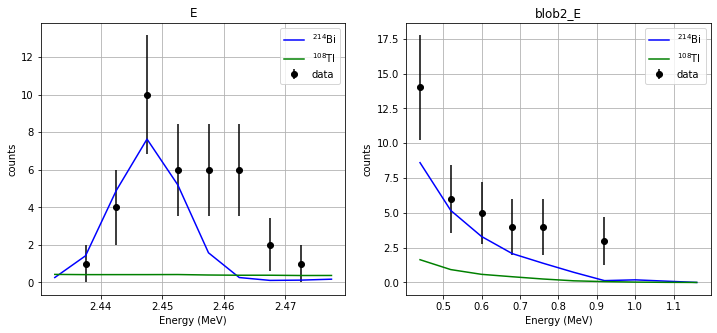

In [21]:
nbkgs = (nevts_Bi_RoI, nevts_Tl_RoI)
nevts_bkg_RoI = np.sum(nbkgs) 
mcs   = (mcbi, mctl)
plt_fanal(data, sel, mcs, nbkgs, 10)

In [22]:
nevts_RoI    = np.sum(sel)
nevts_bb_RoI = nevts_RoI - nevts_bkg_RoI if nevts_RoI > nevts_bkg_RoI else 0
print('Number of observed events in RoI     : {:d}'.format(nevts_RoI))
print('Number of expected bkg events in RoI : {:6.4f}'.format(nevts_bkg_RoI))
print('Best estimation of the signal in RoI : {:6.4f}'.format(nevts_bb_RoI))

Number of observed events in RoI     : 36
Number of expected bkg events in RoI : 25.6650
Best estimation of the signal in RoI : 10.3350


## Estimate the bb0nu half-life

In [23]:
acc_bb     = 0.794
eff_bb_RoI = collpars.eff_bb_RoI
exposure   = collpars.exposure
eff        = acc_bb * eff_bb_RoI
tau        = fn.half_life(nevts_bb_RoI, exposure, eff)

print('number of bb0nu events  : {:6.3f}'.format(nevts_bb_RoI))
print('exposure                : {:6.2f} kg y'.format(exposure))
print('total signal efficiency : {:6.3f}'.format(eff))
print('bb0nu half-life         : {:6.2e} y '.format(tau))

number of bb0nu events  : 10.335
exposure                : 1000.00 kg y
total signal efficiency :  0.412
bb0nu half-life         : 1.10e+26 y 


## Write Out

In [13]:
write = True

if (write):
    of = open('collpars.py', 'a')
    of.write('acc_bb          = {:6.3f}'.format(acc_bb)+'\n')
    of.write('nevts_RoI       = {:6.3f}'.format(nevts_RoI)   +'\n')
    of.write('nevts_bb_RoI    = {:6.3f}'.format(nevts_bb_RoI)+'\n')
    of.write('tau             = {:1.3e}'.format(tau)+' # y \n')
    of.close()